In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import datetime
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from statsmodels.tsa.stattools import adfuller

%matplotlib inline

Using TensorFlow backend.
/home/hechaoli/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Read in the data

DATE
2017-05-01    6.8843
2017-06-01    6.8066
2017-07-01    6.7694
2017-08-01    6.6670
2017-09-01    6.5144
Name: EXCHUS, dtype: float64


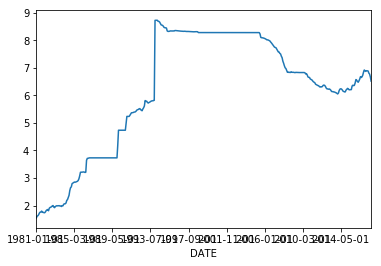

In [2]:
series = pd.read_csv('EXCHUS.csv', header=0, index_col=0, squeeze=True)
#series.loc[series == '.'] = '0.1'
series= pd.to_numeric(series)
print (series.tail())
series.plot()

# Use Augmented Dickey Fuller test to see if the time series has a trend. 

If p-value > 0.05, then accept null hypothesis that the time series is not stationary

If p-value < 0.05, then reject null hypothesis, and the time series is stationary

In [3]:
X = series.values

#try to remove variance using log transform
X = np.log(X)
result = adfuller(X)
print ('p-value is %.5f' % result[1]) #p-value

p-value is 0.00547


# Differencing:

Differencing is a method to remove the time dependence, which includes trends and seasonality.

p-value is 0.00000


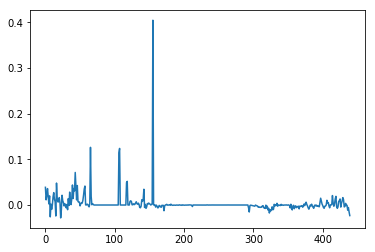

In [4]:
#manually differencing the data
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i-interval]
        diff.append(value)
    return pd.Series(diff)

diff = difference(X, 1)
plt.plot(diff)

"""
#using pandas function
diff = series.diff() #shift
diff.plot()
"""

result = adfuller(diff)
print ('p-value is %.5f' % result[1]) #p-value

In [77]:
#invert differenced value

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# Scaling the data to [-1, 1]

In [6]:
#scale the training and test data to (-1,1)

def scale(train, test):
    #fit scaler
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler= scaler.fit(train)
    
    #transform training data
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    #transform test data
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    
    return scaler, train_scaled, test_scaled

In [64]:
#Invert scaling for a forecastd value
def invert_scale(scaler, value1, value2):
    new_row = [value1] + [value2]
    array = np.array(new_row)
    # print array.shape
    array = array.reshape(1, len(array))
    # print array.shape
    inverted = scaler.inverse_transform(array)
    
    return inverted[0, -1]

# Generating labels

In [8]:
#transform data to a sequence suit for supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# Build LSTM Model in Keras

In [9]:
#let's try a 2-layer lstm model

def build_lstm(layers):
    model = Sequential()
    
    #LSTM(units=50, return_sequences=True, input_shape=(None, 1))
    model.add(LSTM(units = layers[1],
                   return_sequences=True,
                   input_shape = (None, 1)))
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers[2],
                   return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [10]:
def predict(model, data):
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

# Prepare the data

In [95]:
X = series.values

# log transform the data
X = np.log(X)

#differencing the data
diff_values = difference(X, 1)

# transform the data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
print supervised_values.shape

#spit data into training and test set
size = int(len(diff)*0.8) #80/20 split
train, test = supervised_values[:size], supervised_values[size:]

#scale to [-1,1]
scaler, train_scaled, test_scaled = scale(train, test)

#prepare data for the model
X_train, Y_train = train_scaled[:, 0:-1], train_scaled[:, -1]
X_test, Y_test = test_scaled[:, :-1], test_scaled[:, -1]
print X_test.shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print (X_train.shape)
print (X_test.shape)

(440, 2)
(88, 1)
(352, 1, 1)
(88, 1, 1)


In [102]:
nb_epoch = 1000
layers = [1, 50, 100, 1]

model = build_lstm(layers)
model.fit(X_train,
          Y_train,
          batch_size = 1,
          epochs = nb_epoch,
          # validation_split = 0.05,
          verbose = 0,
          shuffle = False)

predictions = predict(model, X_test)

Test MSE: 0.00088


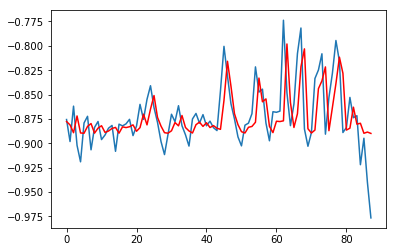

In [103]:
error = mean_squared_error(Y_test, predictions)
print('Test MSE: %.5f' % error)
plt.plot(Y_test)
plt.plot(predictions, color='red')

In [104]:
print predictions[0]
print Y_test[0]

-0.877641
-0.875598194848


In [105]:
x_test = X_test.reshape(X_test.shape[0])
# print X_test.shape

for i in range(len(predictions)):
    # print x_test[i].shape
    # print predictions[i]
    
    #invert scaling
    predictions[i] = invert_scale(scaler, x_test[i], predictions[i])
    
    #invert differencing
    predictions[i] = inverse_difference(X, predictions[i], len(predictions)+1-i)

In [106]:
predictions.shape

(88,)

In [107]:
#inverse tramsformation
predictions = np.exp(predictions)
X = np.exp(X)

Test MSE: 0.00173


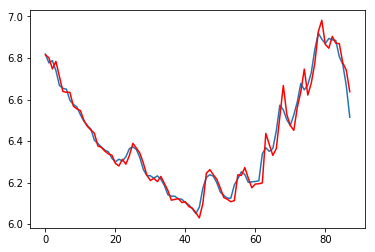

In [108]:
error = mean_squared_error(X[size+1:], predictions)
print('Test MSE: %.5f' % error)
plt.plot(X[size+1:])
plt.plot(predictions, color='red')